# **Malware-Detection**
**Classifying Data as Benign & Malware based on the Static features Generated by the pefile module** <br>
**Trained on Particular Features... Using pefile to extract the same features vectors from the new file and classfying thorugh it**

In [362]:
import sklearn as sk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import os
import xgboost as xgb
import seaborn as sns
import scipy.stats as stats

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn import set_config
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import lightgbm as lgb

import joblib
set_config(display="diagram")

import warnings
warnings.filterwarnings("ignore")

## Data Description

In [2]:
from configparser import ConfigParser
config = ConfigParser()
config.read("./../config.ini")
data_path = config.get("Project", "DATA_PATH") + "static_bm.csv"
print(data_path)

/mnt/d/Malware/train/static_bm.csv


In [3]:
dataframe = pd.read_csv(data_path)
dataframe.head()

1  2  3   4       5  \
0  00000.VirusShare_0002c83153998f9ed51c5a5078de46a6  1  7   0  147456   
1  00001.VirusShare_001d106b8f74e8a92d8d19b39fb4afea  1  6   0   24064   
2  00002.VirusShare_002bc357b589377bef56ad8f763dba4f  1  9   0  204800   
3  00003.VirusShare_002bde0d5afb6a8dbb8ef8441497b180  1  2  50   10752   
4  00004.VirusShare_003dfb95fba39a77ed3309e1a3fbf7f1  1  9   0    5632   

        6       7       8       9       10  ...  82  83  84  85  86   87   88  \
0  309248       0  150944    4096  4194304  ...   0   0   0   0   0  0.0  0.0   
1  164864    1024   12538    4096  4194304  ...   0   0   0   0   0  0.0  0.0   
2    4096  122880   44386  126976  4194304  ...   0   0   0   0   0  0.0  0.0   
3  312832       0  270832  270336  4194304  ...   0   0   0   0   0  0.0  0.0   
4  334336       0    7680    4096  4194304  ...   0   0   0   0   0  0.0  0.0   

    89   90  91  
0  0.0  0.0   0  
1  0.0  0.0   0  
2  0.0  0.0   0  
3  0.0  0.0   0  
4  0.0  0.0   0  

[5 rows x 91 columns]

In [4]:
feature_path = config.get("Project", "DATA_PATH") + "static_bm_features.txt"
features = []
with open(feature_path, 'r') as file:
    while True:
        str = file.readline()
        if not str:
            break
        lst = str.split(' ')
        str = lst[1]
        str = str.rstrip("\n")
        features.append(str)
print(features)

['Name', 'Malicious', 'MajorLinkerVersion', 'MinorLinkerVersion', 'SizeOfCode', 'SizeOfInitializedData', 'SizeOfUninitializedData', 'AddressOfEntryPoint', 'BaseOfCode', 'ImageBase', 'SectionAlignment', 'FileAlignment', 'MajorOperatingSystemVersion', 'MinorOperatingSystemVersion', 'MinorSubsystemVersion', 'SizeOfImage', 'SizeOfHeaders', 'Subsystem', 'DllCharacteristics', 'Directory_Characteristics', 'Directory_TimeDateStamp', 'Directory_NumberOfNamedEntries', 'Directory_NumberOfIdEntries', 'e_magic', 'e_cblp', 'e_cp', 'e_crlc', 'e_cparhdr', 'e_minalloc', 'e_maxalloc', 'e_ss', 'e_sp', 'e_csum', 'e_ip', 'e_cs', 'e_lfarlc', 'e_ovno', 'e_res', 'e_oemid', 'e_oeminfo', 'e_res2', 'e_lfanew', 'MajorImageVersion', 'MinorImageVersion', 'MajorSubsystemVersion', 'SizeOfStackReserve', 'SizeOfStackCommit', 'SizeOfHeapReserve', 'SizeOfHeapCommit', 'LoaderFlags', 'NumberOfRvaAndSizes', 'Num_Suspecious_Sections', 'SectionsMeanEntropy', 'SectionsMinEntropy', 'SectionsMaxEntropy', 'CharacteristicsMean', '

In [5]:
dataframe.columns = features

In [6]:
dataframe.describe()

Malicious  MajorLinkerVersion  MinorLinkerVersion    SizeOfCode  \
count  3646.000000         3646.000000         3646.000000  3.646000e+03   
mean      0.466264            8.072682            7.054306  2.201255e+06   
std       0.498929            5.851986           19.633621  5.850455e+07   
min       0.000000            0.000000            0.000000  0.000000e+00   
25%       0.000000            6.000000            0.000000  1.484800e+04   
50%       0.000000            9.000000            0.000000  3.737600e+04   
75%       1.000000            9.000000            0.000000  1.474560e+05   
max       1.000000           94.000000          255.000000  1.766614e+09   

       SizeOfInitializedData  SizeOfUninitializedData  AddressOfEntryPoint  \
count           3.646000e+03             3.646000e+03         3.646000e+03   
mean            2.473542e+06             3.940940e+04         1.536599e+05   
std             6.356438e+07             5.812349e+05         1.112856e+06   
min             0.000000e+00             0.000000e+00         0.000000e+00   
25%             1.075200e+04             0.000000e+00         5.841000e+03   
50%             4.505600e+04             0.000000e+00         1.446400e+04   
75%             1.693440e+05             0.000000e+00         6.778100e+04   
max             1.918989e+09             2.722560e+07         4.598262e+07   

         BaseOfCode     ImageBase  SectionAlignment  ...  Load_Reserved1  \
count  3.646000e+03  3.646000e+03       3646.000000  ...     3646.000000   
mean   2.238822e+04  2.549493e+10       4436.467361  ...       74.259462   
std    3.409763e+05  4.106203e+11       3763.772141  ...     1552.966001   
min    0.000000e+00  6.553600e+04        128.000000  ...        0.000000   
25%    4.096000e+03  4.194304e+06       4096.000000  ...        0.000000   
50%    4.096000e+03  4.194304e+06       4096.000000  ...        0.000000   
75%    4.096000e+03  2.684355e+08       4096.000000  ...        0.000000   
max    1.613005e+07  6.892780e+12     131072.000000  ...    49203.000000   

       Load_EditList  Load_SecurityCookie  Load_SEHandlerTable  \
count   3.646000e+03         3.646000e+03         3.646000e+03   
mean    3.114145e+06         2.644902e+08         1.476620e+07   
std     6.813148e+07         1.141788e+09         1.608247e+08   
min     0.000000e+00         0.000000e+00         0.000000e+00   
25%     0.000000e+00         0.000000e+00         0.000000e+00   
50%     0.000000e+00         0.000000e+00         0.000000e+00   
75%     0.000000e+00         4.283672e+06         0.000000e+00   
max     1.869377e+09         5.432505e+09         4.051763e+09   

       Load_SEHandlerCount  Load_GuardCFCheckFunctionPointer  Load_Reserved2  \
count         3.646000e+03                      3.646000e+03    3.646000e+03   
mean          5.459323e+06                      2.897398e+15    6.866342e+15   
std           1.186655e+08                      1.343605e+17    3.108397e+17   
min           0.000000e+00                      0.000000e+00    0.000000e+00   
25%           0.000000e+00                      0.000000e+00    0.000000e+00   
50%           0.000000e+00                      0.000000e+00    0.000000e+00   
75%           0.000000e+00                      4.655075e+04    8.525000e+03   
max           4.089491e+09                      7.521910e+18    1.693260e+19   

       Load_GuardCFFunctionTable  Load_GuardCFFunctionCount  Load_GuardFlags  
count               3.646000e+03               3.646000e+03     3.646000e+03  
mean                1.885360e+15               4.305335e+15     3.602429e+08  
std                 1.138420e+17               1.838152e+17     9.452919e+08  
min                 0.000000e+00               0.000000e+00     0.000000e+00  
25%                 0.000000e+00               0.000000e+00     0.000000e+00  
50%                 0.000000e+00               0.000000e+00     0.000000e+00  
75%                 0.000000e+00               0.000000e+00     2.5

## Exploratory Data Analysis

**<pre>Points:
    First Column Contains the Name of the files, which is free to drop
    Second Column contains the classes predction, Separate it from Train<pre>**

In [7]:
dataframe.drop('Name', axis=1, inplace=True)
dataframe.head()

Malicious  MajorLinkerVersion  MinorLinkerVersion  SizeOfCode  \
0          1                   7                   0      147456   
1          1                   6                   0       24064   
2          1                   9                   0      204800   
3          1                   2                  50       10752   
4          1                   9                   0        5632   

   SizeOfInitializedData  SizeOfUninitializedData  AddressOfEntryPoint  \
0                 309248                        0               150944   
1                 164864                     1024                12538   
2                   4096                   122880                44386   
3                 312832                        0               270832   
4                 334336                        0                 7680   

   BaseOfCode  ImageBase  SectionAlignment  ...  Load_Reserved1  \
0        4096    4194304              4096  ...               0   
1        4096    4194304              4096  ...               0   
2      126976    4194304              4096  ...               0   
3      270336    4194304              4096  ...               0   
4        4096    4194304              4096  ...               0   

   Load_EditList  Load_SecurityCookie  Load_SEHandlerTable  \
0              0                    0                    0   
1              0                    0                    0   
2              0                    0                    0   
3              0                    0                    0   
4              0                    0                    0   

   Load_SEHandlerCount  Load_GuardCFCheckFunctionPointer  Load_Reserved2  \
0                    0                               0.0             0.0   
1                    0                               0.0             0.0   
2                    0                               0.0             0.0   
3                    0                               0.0             0.0   
4                    0                               0.0             0.0   

   Load_GuardCFFunctionTable  Load_GuardCFFunctionCount  Load_GuardFlags  
0                        0.0                        0.0                0  
1                        0.0                        0.0                0  
2                        0.0                        0.0                0  
3                        0.0                        0.0                0  
4                        0.0                        0.0                0  

[5 rows x 90 columns]

- Shuffle the Dataset

In [8]:
dataframe = dataframe.sample(frac=1).reset_index(drop=True)
dataframe.head()

Malicious  MajorLinkerVersion  MinorLinkerVersion  SizeOfCode  \
0          1                  40                 186        1024   
1          1                   8                   0      272896   
2          1                  11                   0      336384   
3          1                   8                   0      178688   
4          0                  14                   0        7168   

   SizeOfInitializedData  SizeOfUninitializedData  AddressOfEntryPoint  \
0                   4608                        0                73841   
1                   2048                        0               280958   
2                1273856                        0                70496   
3                  18432                        0               181764   
4                  17408                        0                 8768   

   BaseOfCode   ImageBase  SectionAlignment  ...  Load_Reserved1  \
0       73728     4194304              4096  ...               0   
1        8192     4194304              8192  ...               0   
2        4096   268435456              4096  ...               0   
3        4096     4194304              4096  ...               0   
4        4096  5368709120              4096  ...               0   

   Load_EditList  Load_SecurityCookie  Load_SEHandlerTable  \
0              0                    0                    0   
1              0                    0                    0   
2              0            268905392            268858736   
3              0                    0                    0   
4              0           5368729600                    0   

   Load_SEHandlerCount  Load_GuardCFCheckFunctionPointer  Load_Reserved2  \
0                    0                      0.000000e+00    0.000000e+00   
1                    0                      0.000000e+00    0.000000e+00   
2                   35                      2.689026e+08    0.000000e+00   
3                    0                      0.000000e+00    0.000000e+00   
4                    0                      5.368722e+09    5.368722e+09   

   Load_GuardCFFunctionTable  Load_GuardCFFunctionCount  Load_GuardFlags  
0                        0.0               0.000000e+00                0  
1                        0.0               0.000000e+00                0  
2                        0.0               4.294967e+09                0  
3                        0.0               0.000000e+00                0  
4                        0.0               0.000000e+00              256  

[5 rows x 90 columns]

- Get rid of null values

In [9]:
obj = dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3646 entries, 0 to 3645
Data columns (total 90 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Malicious                           3646 non-null   int64  
 1   MajorLinkerVersion                  3646 non-null   int64  
 2   MinorLinkerVersion                  3646 non-null   int64  
 3   SizeOfCode                          3646 non-null   int64  
 4   SizeOfInitializedData               3646 non-null   int64  
 5   SizeOfUninitializedData             3646 non-null   int64  
 6   AddressOfEntryPoint                 3646 non-null   int64  
 7   BaseOfCode                          3646 non-null   int64  
 8   ImageBase                           3646 non-null   int64  
 9   SectionAlignment                    3646 non-null   int64  
 10  FileAlignment                       3646 non-null   int64  
 11  MajorOperatingSystemVersion         3646 no

- Find Types of data the column Have

In [10]:
unique=[]
cat_cols = []
data_unique = []
for i in range(len(dataframe.columns)):
    val = dataframe.iloc[:, i].nunique()
    if(val < 10):
        data_unique.append(dataframe.iloc[:, i].unique())
        cat_cols.append(i)
    unique.append(val)
    
print(cat_cols)
print(unique)


[0, 9, 10, 12, 13, 16, 18, 20, 22, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 39, 43, 46, 47, 48, 49, 62, 63, 64]
[2, 37, 52, 803, 842, 108, 2134, 78, 63, 5, 5, 13, 8, 5, 511, 10, 4, 31, 2, 234, 8, 14, 1, 13, 12, 4, 6, 7, 7, 4, 11, 8, 10, 7, 9, 7, 1, 28, 25, 1, 44, 18, 21, 5, 19, 23, 9, 7, 5, 6, 22, 3089, 1678, 2737, 325, 37, 37, 2643, 1234, 2387, 51, 51, 1, 3, 4, 49, 21, 2325, 28, 24, 17, 17, 17, 17, 17, 17, 17, 18, 17, 16, 12, 16, 643, 580, 157, 308, 684, 574, 599, 583]


In [11]:
count=0
for i in range(len(unique)):
    if(unique[i] == 1):
        print(i)
        count+=1
print(count) 36
39
62

4


- droping the columns with one value

In [12]:
for i in range(len(unique)-count):
    if(unique[i] == 1):
        dataframe.drop(dataframe.columns[i], axis=1, inplace=True)
        del unique[i]
        i-=1

 - VersionData

In [13]:
j=0
cols_not_norm = []
for i in dataframe.columns:
    if("version" in i.lower()):
        print(i, end=' ')
        print(unique[j])
        cols_not_norm.append(j)
    j+=1

print(cols_not_norm)

MajorLinkerVersion 37
MinorLinkerVersion 52
MajorOperatingSystemVersion 13
MinorOperatingSystemVersion 8
MinorSubsystemVersion 5
MajorImageVersion 18
MinorImageVersion 21
MajorSubsystemVersion 5
Load_CSDVersion 16
[1, 2, 11, 12, 13, 38, 39, 40, 75]


- Since Version is categorical and many data in the pefile doest know whether the categorical or numberical, its better to leave as it is... since we are using xgboost algorithm, and also its better to normalize the values of greater range which are confirmed numerical

In [14]:
to_norm = []
for i in range(len(dataframe.columns)):
    val = dataframe.iloc[:, i].nunique()
    dtype = dataframe.dtypes[dataframe.columns[i]]
    if(val > 100 or dtype=='float64'):
        data_unique.append(dataframe.iloc[:, i].unique())
        to_norm.append(i)
        
print(to_norm)
print(unique)

[3, 4, 5, 6, 14, 19, 48, 49, 50, 51, 54, 55, 56, 63, 78, 79, 80, 81, 82, 83, 84, 85]
[2, 37, 52, 803, 842, 108, 2134, 78, 63, 5, 5, 13, 8, 5, 511, 10, 4, 31, 2, 234, 8, 14, 13, 12, 4, 6, 7, 7, 4, 11, 8, 10, 7, 9, 7, 28, 25, 44, 18, 21, 5, 19, 23, 9, 7, 5, 6, 22, 3089, 1678, 2737, 325, 37, 37, 2643, 1234, 2387, 51, 51, 3, 4, 49, 21, 2325, 28, 24, 17, 17, 17, 17, 17, 17, 17, 18, 17, 16, 12, 16, 643, 580, 157, 308, 684, 574, 599, 583]


## Outliers

- Analysis that to be done to the numerical values

In [15]:
%matplotlib inline
def plot(columns):
    plt.rcParams["figure.figsize"] = (len(columns), len(columns)*8)
    x = int(len(columns)/2)
    fig, axis = plt.subplots(x, 2)
    count = 0
    for i in range(x):
        for j in range(2):
            if(count<len(columns)):
                axis[i, j].plot(dataframe.iloc[:, count])
                axis[i, j].set_title(dataframe.columns[columns[count]])
            else:
                break
            count+=1
    

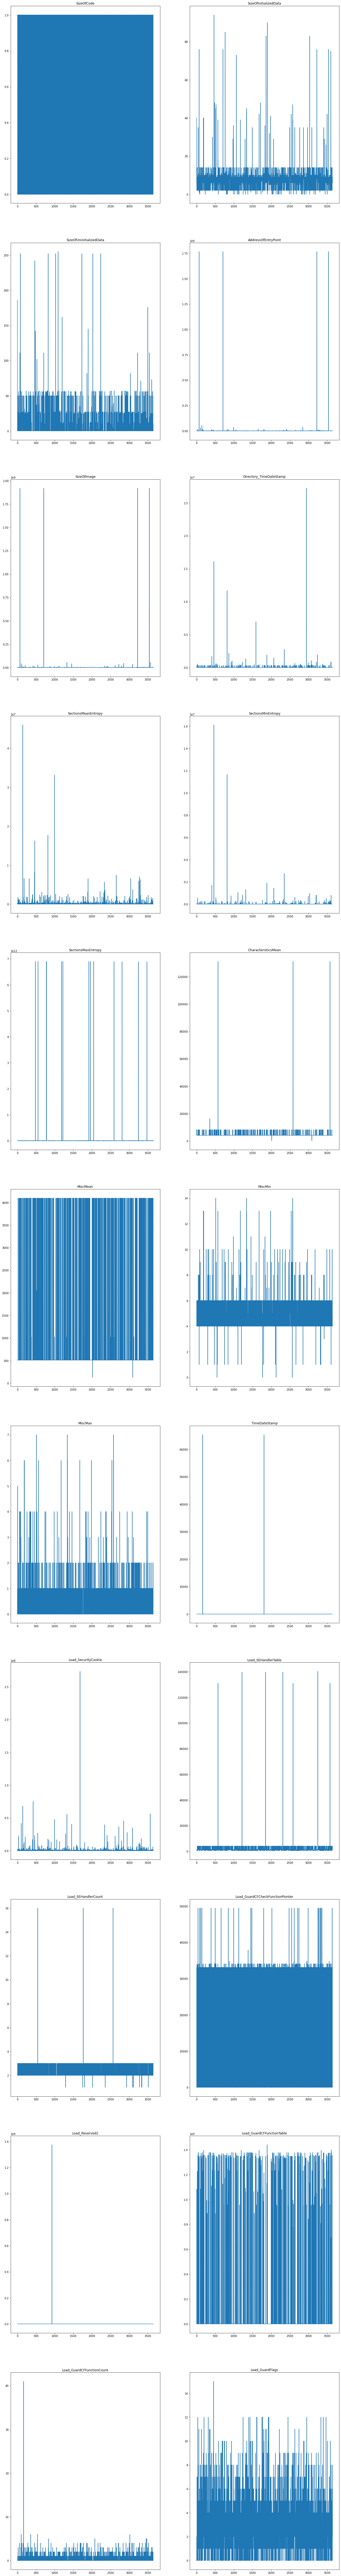

In [16]:
plot(to_norm)

- As we can see there were outliers in almost all the numerical columns 

### Box Plot

In [17]:
col_box = []
for i in to_norm:
    col_box.append(dataframe.columns[i])

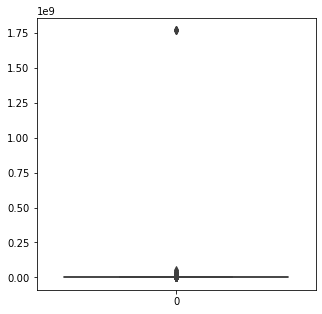

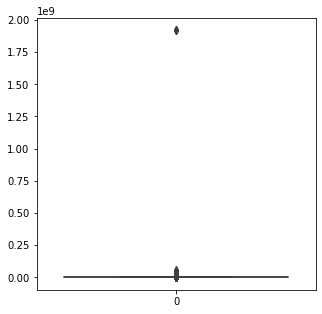

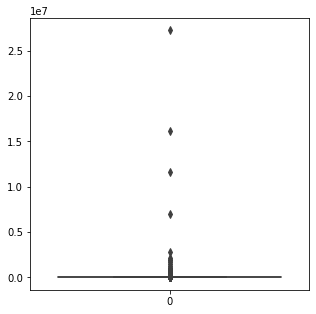

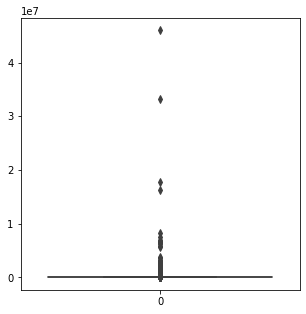

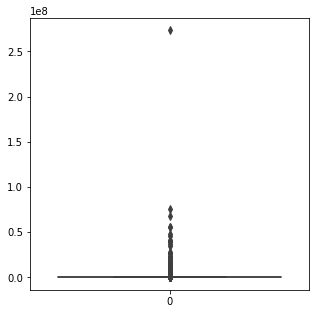

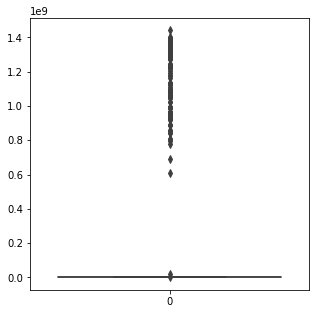

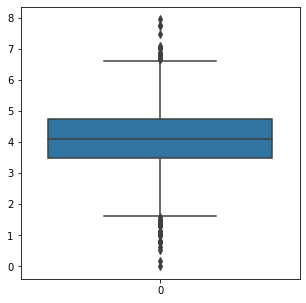

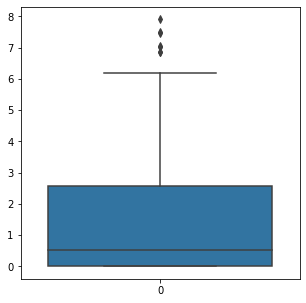

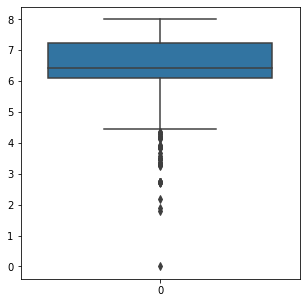

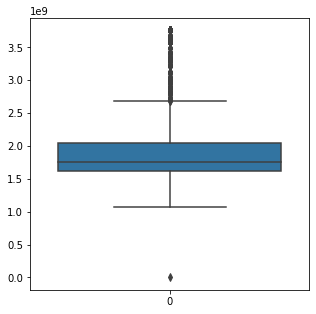

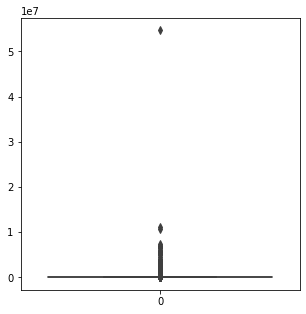

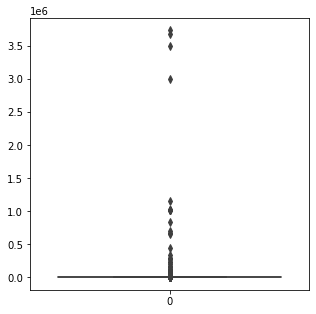

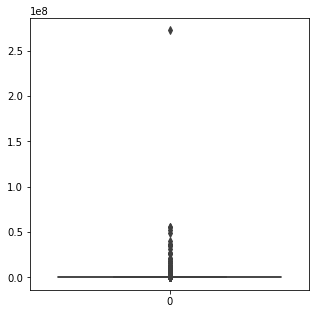

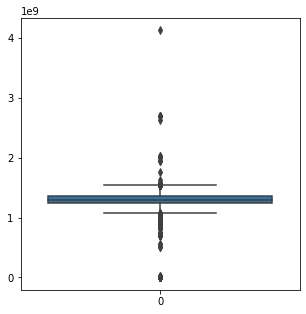

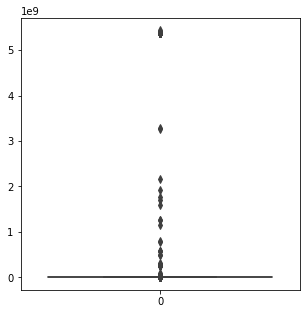

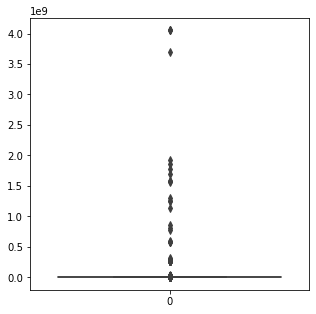

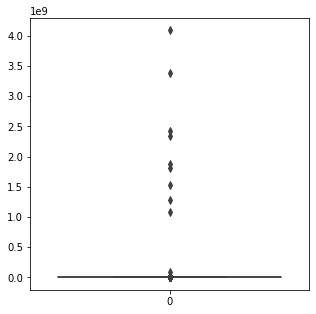

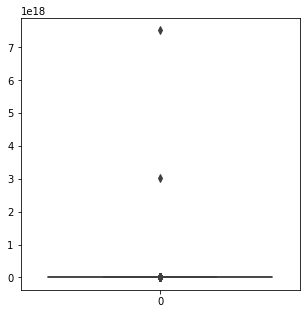

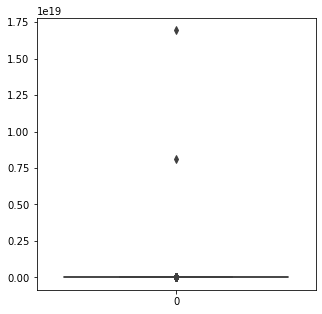

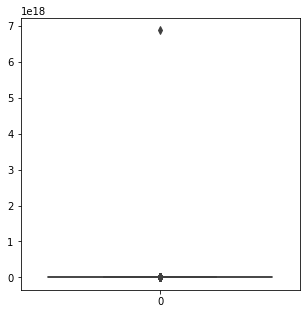

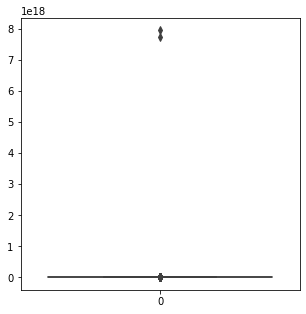

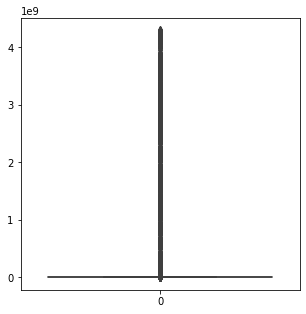

In [18]:
plt.rcParams["figure.figsize"] = (5, 5)
for i in to_norm:
    sns.boxplot(data=dataframe[dataframe.columns[i]], )
    plt.show()

### Z-Score Test for removing outliers

In [19]:
'''
z = np.abs(stats.zscore(dataframe[dataframe.columns[to_norm]]))
dataframe = dataframe[(z<3).all(axis=1)]
'''

'\nz = np.abs(stats.zscore(dataframe[dataframe.columns[to_norm]]))\ndataframe = dataframe[(z<3).all(axis=1)]\n'

In [20]:
len(dataframe)

3646

In [21]:
def determine_outlier_thresholds_iqr(dataframe, columns, th1=0.25, th3=0.75):
    quartile1 = dataframe[columns].quantile(0.25)
    quartile3 = dataframe[columns].quantile(0.75)
    iqr = quartile3 - quartile1
    upper_limit = quartile3 + iqr*1.5
    lower_limit = quartile1 - iqr*1.5
    return lower_limit, upper_limit

In [22]:
def check_outliers_iqr(dataframe, col_name):
    lower_limit, upper_limit = determine_outlier_thresholds_iqr(dataframe, col_name)
    if dataframe[(dataframe[col_name] > upper_limit) | (dataframe[col_name] < lower_limit)].any(axis=None):
        return True
    else: 
        return False

In [23]:
!pip3 install tabulate
from tabulate import tabulate
def replace_with_thresholds_iqr(dataframe,cols, th1=0.25, th3=0.75, replace=True):
    
    data = []
    for col_name in cols:
        if col_name != 'Outcome':
            outliers_ = check_outliers_iqr(dataframe,col_name)
            count = None
            lower_limit, upper_limit = determine_outlier_thresholds_iqr(dataframe, col_name, th1, th3)
            if outliers_:
                count = dataframe[(dataframe[col_name] > upper_limit) | (dataframe[col_name] < lower_limit)][col_name].count()
                if replace: 
                    if lower_limit < 0:
                        # We don't want to replace with negative values, right!
                        dataframe.loc[(dataframe[col_name] > upper_limit), col_name] = upper_limit
                    else:
                        dataframe.loc[(dataframe[col_name] < lower_limit), col_name] = lower_limit
                        dataframe.loc[(dataframe[col_name] > upper_limit), col_name] = upper_limit
            outliers_status = check_outliers_iqr(dataframe, col_name)
            data.append([outliers_, outliers_status, count, col_name, lower_limit, upper_limit ])
    table = tabulate(data, headers=['Outliers (Previously)', 'Outliers', 'Count', 'Column', 'Lower Limit', 'Upper Limit'], tablefmt='rst', numalign='right')
    print("Removing Outliers using IQR")
    print(table)

In [24]:
for x in (dataframe['SizeOfCode'] < 0):
    if x is True:
        print(yes)

In [25]:
replace_with_thresholds_iqr(dataframe, dataframe.columns[to_norm])

Removing Outliers using IQR
=======================  ==========  =======  ================================  =============  =============
Outliers (Previously)    Outliers      Count  Column                              Lower Limit    Upper Limit
=======================  ==========  =======  ================================  =============  =============
True                     False           385  SizeOfCode                              -184064         346368
True                     False           481  SizeOfInitializedData                   -227136         407232
True                     False           560  SizeOfUninitializedData                       0              0
True                     False           541  AddressOfEntryPoint                      -87069         160691
True                     False           431  SizeOfImage                             -378880         849920
True                     False           363  Directory_TimeDateStamp                       0       

In [27]:
len(dataframe)

3646

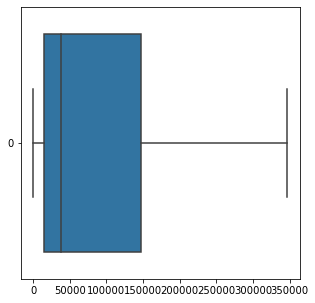

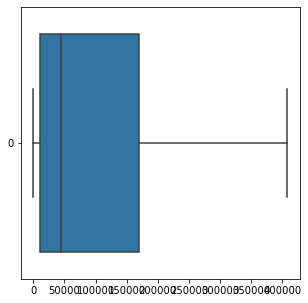

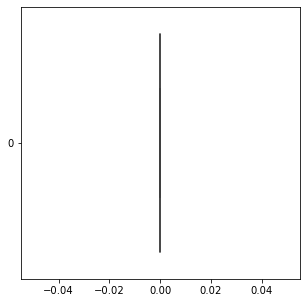

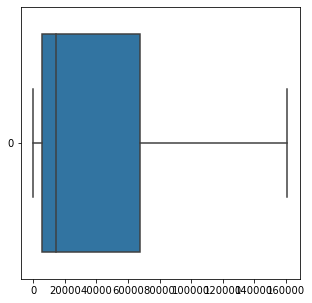

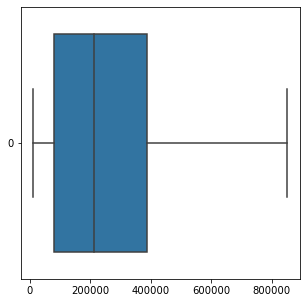

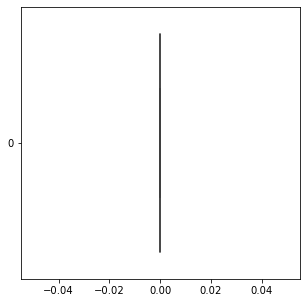

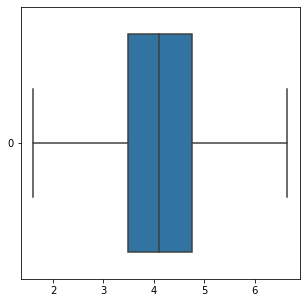

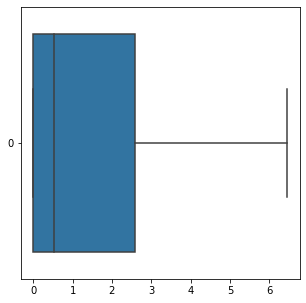

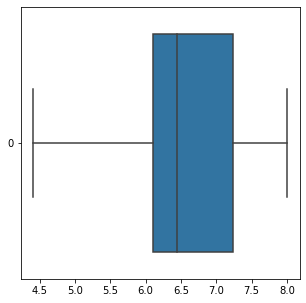

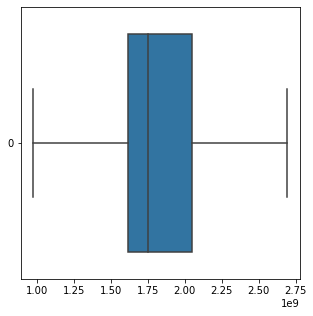

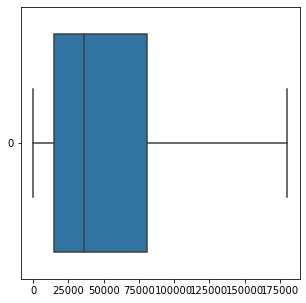

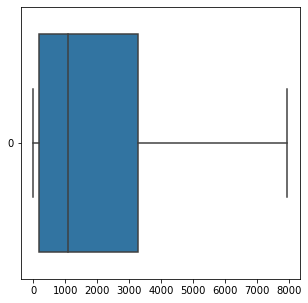

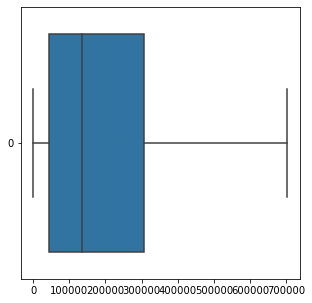

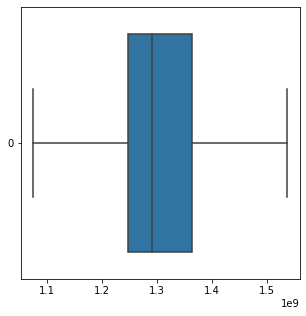

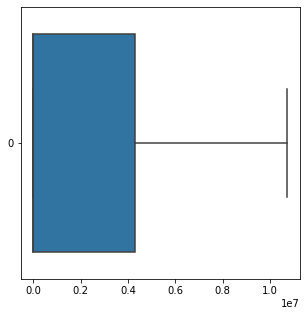

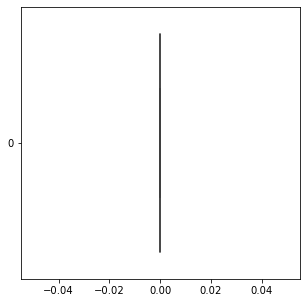

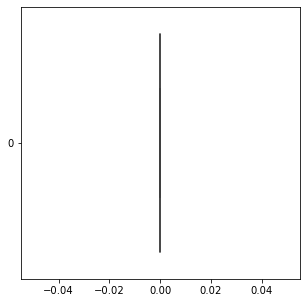

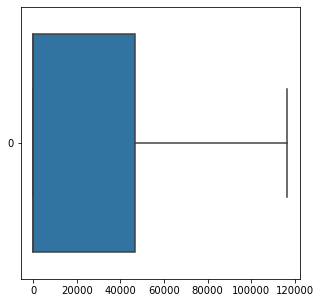

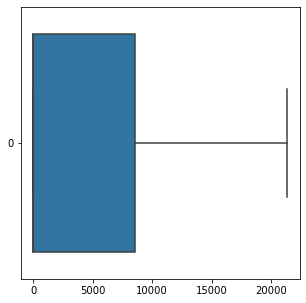

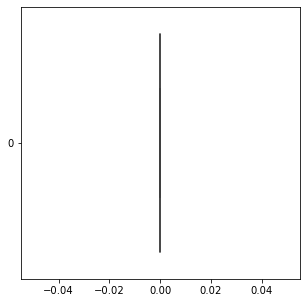

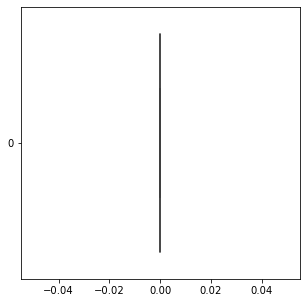

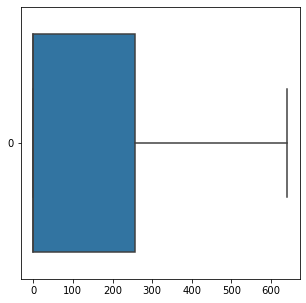

In [28]:
for i in to_norm:
    sns.boxplot(data=dataframe[dataframe.columns[i]], orient="h")
    plt.ylim()
    plt.show()

## Correlation Map

In [18]:
len(dataframe.columns)

86

/home/mnk/python/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


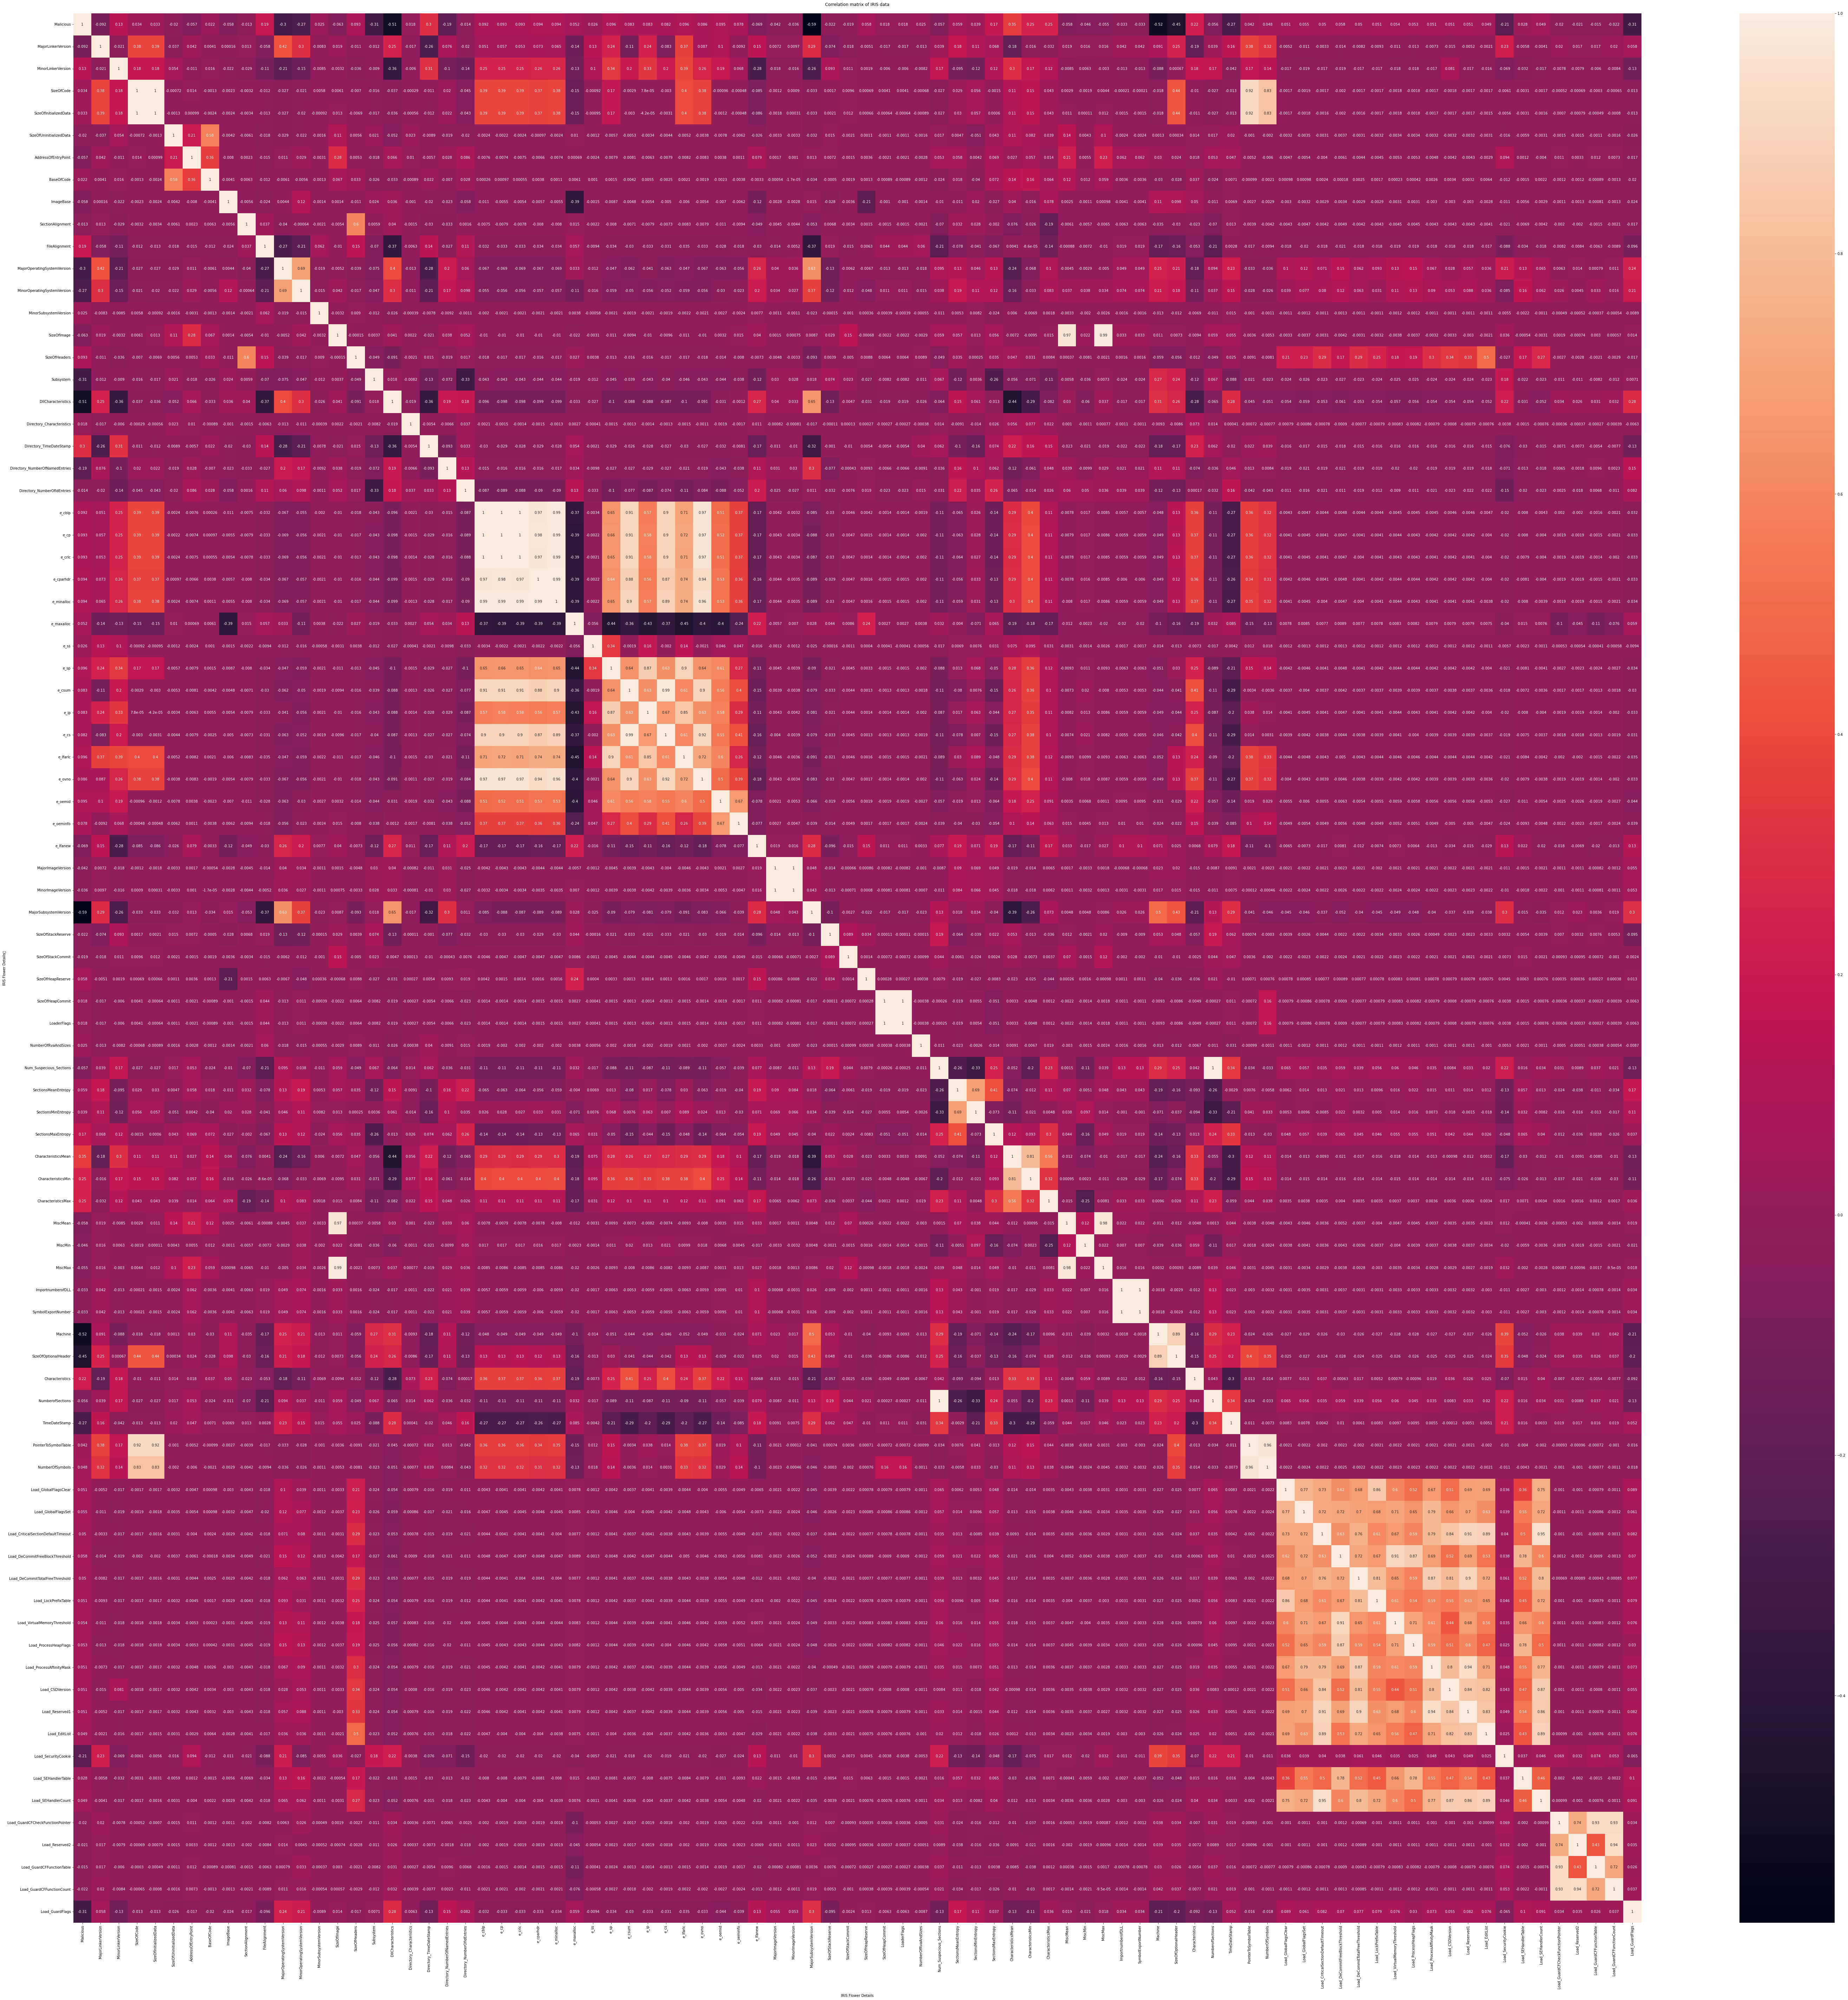

In [19]:
corr = dataframe.corr()
plt.figure(figsize=(100, 100))
hm = sns.heatmap(corr, annot = True)
hm.set(xlabel='\nIRIS Flower Details', ylabel='IRIS Flower Details\t', title = "Correlation matrix of IRIS data\n")
plt.show()

In [92]:
print(len(dataframe.columns))
print(len(cols_not_norm))
scale_features = []
for feat in dataframe.columns:
    if feat not in dataframe.columns[cols_not_norm]:
        scale_features.append(feat)

scale_features = scale_features[1:]
print(len(scale_features))

86
9
76


## PreProcessing - Pipeline

In [93]:
X = dataframe.iloc[:, 1: ]
y = dataframe.iloc[:, 0]

In [94]:
print(X.shape)

(3646, 85)


In [145]:

preprocessor = ColumnTransformer(
            [
                ('mm', MinMaxScaler(feature_range=(0, 1)) , scale_features),
            ],
                remainder='passthrough'
        )

preprocessor.get_params()

{'n_jobs': None,
 'remainder': 'passthrough',
 'sparse_threshold': 0.3,
 'transformer_weights': None,
 'transformers': [('mm',
   MinMaxScaler(),
   ['SizeOfCode',
    'SizeOfInitializedData',
    'SizeOfUninitializedData',
    'AddressOfEntryPoint',
    'BaseOfCode',
    'ImageBase',
    'SectionAlignment',
    'FileAlignment',
    'SizeOfImage',
    'SizeOfHeaders',
    'Subsystem',
    'DllCharacteristics',
    'Directory_Characteristics',
    'Directory_TimeDateStamp',
    'Directory_NumberOfNamedEntries',
    'Directory_NumberOfIdEntries',
    'e_cblp',
    'e_cp',
    'e_crlc',
    'e_cparhdr',
    'e_minalloc',
    'e_maxalloc',
    'e_ss',
    'e_sp',
    'e_csum',
    'e_ip',
    'e_cs',
    'e_lfarlc',
    'e_ovno',
    'e_oemid',
    'e_oeminfo',
    'e_lfanew',
    'SizeOfStackReserve',
    'SizeOfStackCommit',
    'SizeOfHeapReserve',
    'SizeOfHeapCommit',
    'LoaderFlags',
    'NumberOfRvaAndSizes',
    'Num_Suspecious_Sections',
    'SectionsMeanEntropy',
    'Section

## Model - Xgboost

In [246]:
params = {"objective" : "binary:logistic", "alpha": 10}
paramsgs = {"classifier__n_estimators" : [100, 250, 400],
             'classifier__learning_rate':[0.1, 0.2],
             "classifier__min_child_weight": [3, 4],
             'classifier__max_depth' : [4, 5]}
xgb_clf = xgb.XGBClassifier(**params)


In [237]:
xgb_pipe = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('classifier', xgb_clf)
        ])
xgb_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('mm', MinMaxScaler(),
                                                  ['SizeOfCode',
                                                   'SizeOfInitializedData',
                                                   'SizeOfUninitializedData',
                                                   'AddressOfEntryPoint',
                                                   'BaseOfCode', 'ImageBase',
                                                   'SectionAlignment',
                                                   'FileAlignment',
                                                   'SizeOfImage',
                                                   'SizeOfHeaders', 'Subsystem',
                                                   'DllCharacteristics',
                                                   'Directory_Characteristics',
                                                   'Dir...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None, ...))])

In [238]:
X.head()

MajorLinkerVersion  MinorLinkerVersion  SizeOfCode  SizeOfInitializedData  \
0                  40                 186        1024                   4608   
1                   8                   0      272896                   2048   
2                  11                   0      336384                1273856   
3                   8                   0      178688                  18432   
4                  14                   0        7168                  17408   

   SizeOfUninitializedData  AddressOfEntryPoint  BaseOfCode   ImageBase  \
0                        0                73841       73728     4194304   
1                        0               280958        8192     4194304   
2                        0                70496        4096   268435456   
3                        0               181764        4096     4194304   
4                        0                 8768        4096  5368709120   

   SectionAlignment  FileAlignment  ...  Load_Reserved1  Load_EditList  \
0              4096            512  ...               0              0   
1              8192            512  ...               0              0   
2              4096            512  ...               0              0   
3              4096            512  ...               0              0   
4              4096            512  ...               0              0   

   Load_SecurityCookie  Load_SEHandlerTable  Load_SEHandlerCount  \
0                    0                    0                    0   
1                    0                    0                    0   
2            268905392            268858736                   35   
3                    0                    0                    0   
4           5368729600                    0                    0   

   Load_GuardCFCheckFunctionPointer  Load_Reserved2  \
0                      0.000000e+00    0.000000e+00   
1                      0.000000e+00    0.000000e+00   
2                      2.689026e+08    0.000000e+00   
3                      0.000000e+00    0.000000e+00   
4                      5.368722e+09    5.368722e+09   

   Load_GuardCFFunctionTable  Load_GuardCFFunctionCount  Load_GuardFlags  
0                        0.0               0.000000e+00                0  
1                        0.0               0.000000e+00                0  
2                        0.0               4.294967e+09                0  
3                        0.0               0.000000e+00                0  
4                        0.0               0.000000e+00              256  

[5 rows x 85 columns]

In [239]:
preprocessor.fit(X, y)

ColumnTransformer(remainder='passthrough',
                  transformers=[('mm', MinMaxScaler(),
                                 ['SizeOfCode', 'SizeOfInitializedData',
                                  'SizeOfUninitializedData',
                                  'AddressOfEntryPoint', 'BaseOfCode',
                                  'ImageBase', 'SectionAlignment',
                                  'FileAlignment', 'SizeOfImage',
                                  'SizeOfHeaders', 'Subsystem',
                                  'DllCharacteristics',
                                  'Directory_Characteristics',
                                  'Directory_TimeDateStamp',
                                  'Directory_NumberOfNamedEntries',
                                  'Directory_NumberOfIdEntries', 'e_cblp',
                                  'e_cp', 'e_crlc', 'e_cparhdr', 'e_minalloc',
                                  'e_maxalloc', 'e_ss', 'e_sp', 'e_csum',
                                  'e_ip', 'e_cs', 'e_lfarlc', 'e_ovno',
                                  'e_oemid', ...])])

In [240]:
xgb_pipe.fit(X, y)

[22:31:01] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('mm', MinMaxScaler(),
                                                  ['SizeOfCode',
                                                   'SizeOfInitializedData',
                                                   'SizeOfUninitializedData',
                                                   'AddressOfEntryPoint',
                                                   'BaseOfCode', 'ImageBase',
                                                   'SectionAlignment',
                                                   'FileAlignment',
                                                   'SizeOfImage',
                                                   'SizeOfHeaders', 'Subsystem',
                                                   'DllCharacteristics',
                                                   'Directory_Characteristics',
                                                   'Dir...
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, ...))])

In [247]:
xgb_pipe_grid = GridSearchCV(xgb_pipe,
                     param_grid=paramsgs,
                     cv=5,
                     verbose=1)

In [248]:
xgb_pipe_grid.fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[22:37:52] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.

[22:37:52] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.

[22:37:53] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.

[22:37:54] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.

[22:37:54] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.

[22:37:54] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.

[22:37:55] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.

[22:37:55] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.

[22:37:56] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.

[22:37:57] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are

[22:39:22] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.

[22:39:23] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.

[22:39:25] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.

[22:39:26] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.

[22:39:28] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.

[22:39:29] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.

[22:39:30] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.

[22:39:31] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.

[22:39:32] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.

[22:39:34] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.

[22:39:36] WARNING: ../src/learner.cc:767: 
Parame

[22:41:32] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.

[22:41:33] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.

[22:41:35] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.

[22:41:37] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.

[22:41:40] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.

[22:41:43] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.

[22:41:48] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.

[22:41:51] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.

[22:41:52] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.

[22:41:53] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.

[22:41:55] WARNING: ../src/learner.cc:767: 
Parame

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('mm',
                                                                         MinMaxScaler(),
                                                                         ['SizeOfCode',
                                                                          'SizeOfInitializedData',
                                                                          'SizeOfUninitializedData',
                                                                          'AddressOfEntryPoint',
                                                                          'BaseOfCode',
                                                                          'ImageBase',
                                                                          'SectionAlignment',
                                                                          'FileAlignment',
                                                                          'SizeOfImage',
                                                                          'SizeOfHeaders',
                                                                          'Subsystem',
                                                                          'DllCharacteristics',
                                                                          'Dir...
                                                      max_delta_step=0,
                                                      max_depth=6, max_leaves=0,
                                                      min_child_weight=1,
                                                      missing=nan,
                                                      monotone_constraints='()',
                                                      n_estimators=100,
                                                      n_jobs=0,
                                                      num_parallel_tree=1, ...))]),
             param_grid={'classifier__colsample_by_tree': [0.2, 0.3],
                         'classifier__learning_rate': [0.1, 0.05],
                         'classifier__max_depth': [3, 5],
                         'classifier__min_child_weight': [3, 5],
                         'classifier__n_estimators': [250, 400, 750]},
             verbose=1)

In [253]:
print(xgb_pipe_grid.predict(pd.DataFrame((dataframe.iloc[3444:3445, 1:]), columns=dataframe.columns[1:])))
print(dataframe.iloc[3444, 0])

[0]
0


In [254]:
print(xgb_pipe_grid)
print(xgb_pipe_grid.best_params_)
print(xgb_pipe_grid.best_score_)
print(xgb_pipe)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('mm',
                                                                         MinMaxScaler(),
                                                                         ['SizeOfCode',
                                                                          'SizeOfInitializedData',
                                                                          'SizeOfUninitializedData',
                                                                          'AddressOfEntryPoint',
                                                                          'BaseOfCode',
                                                                          'ImageBase',
                                                                          'SectionAlignment',
                    

In [255]:
train = xgb.DMatrix(data=dataframe.iloc[:, 1:], label=dataframe.iloc[:, 0])

xgb_cv = xgb.cv(dtrain=train, params=params, nfold=8 , num_boost_round=50, early_stopping_rounds=10, metrics="auc", seed=133)
xgb_cv.tail()

train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
26        0.998698       0.000175       0.995290      0.001721
27        0.998713       0.000184       0.995297      0.001726
28        0.998725       0.000190       0.995295      0.001721
29        0.998731       0.000192       0.995302      0.001731
30        0.998736       0.000195       0.995312      0.001745

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

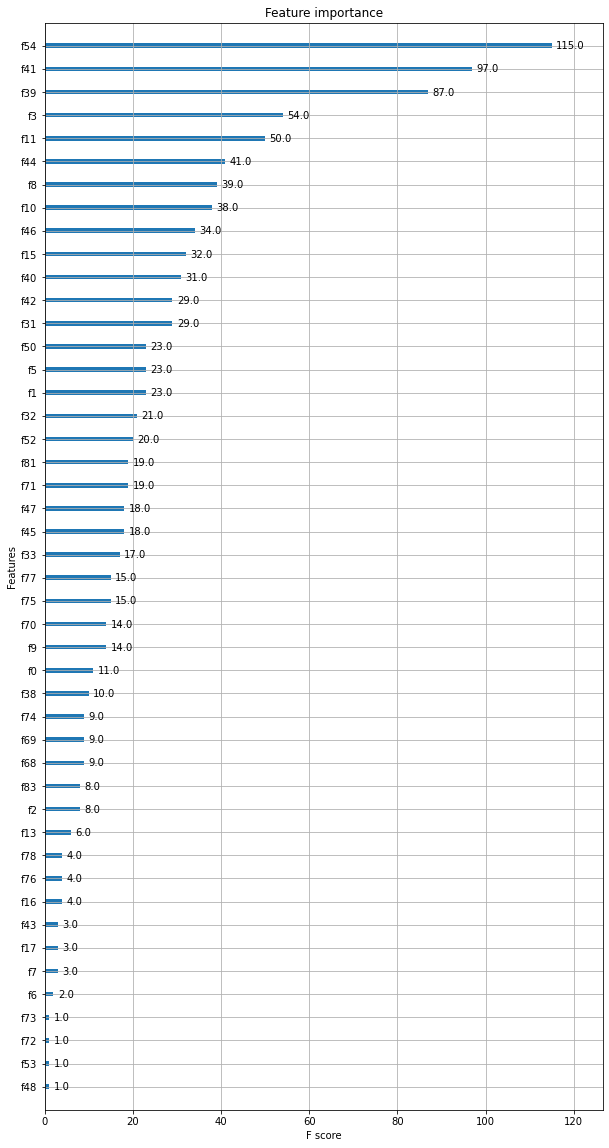

In [293]:
fig, ax = plt.subplots(figsize=(10, 20))
xgb.plot_importance(xgb_pipe_grid.best_estimator_._final_estimator, ax=ax)

In [24]:
xgb_cv.tail()

train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
45        0.997889       0.000259       0.995355      0.001812
46        0.997926       0.000260       0.995382      0.001847
47        0.997963       0.000247       0.995396      0.001792
48        0.997997       0.000258       0.995442      0.001773
49        0.998028       0.000272       0.995491      0.001767

In [264]:
y = xgb_pipe_grid.predict(dataframe.iloc[:, 1:])
y_test = dataframe.iloc[:, 0]
print(accuracy_score(y, y_test))

0.9709270433351618


In [272]:
xgb_clf.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 10,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'alpha': 10}

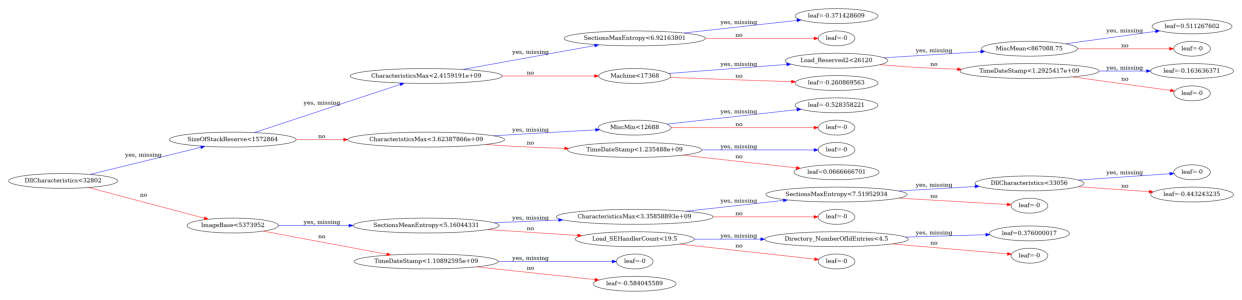

In [270]:
xgb.plot_tree(xgb_clf, rankdir='LR'); plt.show()

In [306]:
print(classification_report(y_test, y))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1946
           1       0.96      0.98      0.97      1700

    accuracy                           0.97      3646
   macro avg       0.97      0.97      0.97      3646
weighted avg       0.97      0.97      0.97      3646



# Model - Random Forest

In [277]:
param_grid = { 
    'classifier__n_estimators': [100, 250],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__max_depth' : [4,5],
    'classifier__criterion' :['gini', 'entropy']
}

rf_clf = RandomForestClassifier(random_state=42)


In [278]:
rf_pipe = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('classifier', rf_clf)
        ])
rf_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('mm', MinMaxScaler(),
                                                  ['SizeOfCode',
                                                   'SizeOfInitializedData',
                                                   'SizeOfUninitializedData',
                                                   'AddressOfEntryPoint',
                                                   'BaseOfCode', 'ImageBase',
                                                   'SectionAlignment',
                                                   'FileAlignment',
                                                   'SizeOfImage',
                                                   'SizeOfHeaders', 'Subsystem',
                                                   'DllCharacteristics',
                                                   'Directory_Characteristics',
                                                   'Directory_TimeDateStamp',
                                                   'Directory_NumberOfNamedEntries',
                                                   'Directory_NumberOfIdEntries',
                                                   'e_cblp', 'e_cp', 'e_crlc',
                                                   'e_cparhdr', 'e_minalloc',
                                                   'e_maxalloc', 'e_ss', 'e_sp',
                                                   'e_csum', 'e_ip', 'e_cs',
                                                   'e_lfarlc', 'e_ovno',
                                                   'e_oemid', ...])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [279]:
rf_grid_pipe = GridSearchCV(rf_pipe,
                     param_grid=param_grid, 
                    cv= 8, verbose=1)

In [280]:
rf_grid_pipe.fit(X_train, y_train)

Fitting 8 folds for each of 16 candidates, totalling 128 fits


GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('mm',
                                                                         MinMaxScaler(),
                                                                         ['SizeOfCode',
                                                                          'SizeOfInitializedData',
                                                                          'SizeOfUninitializedData',
                                                                          'AddressOfEntryPoint',
                                                                          'BaseOfCode',
                                                                          'ImageBase',
                                                                          'SectionAlignment',
                                                                          'FileAlignment',
                                                                          'SizeOfImage',
                                                                          'SizeOfHeaders',
                                                                          'Subsystem',
                                                                          'DllCharacteristics',
                                                                          'Dir...
                                                                          'e_crlc',
                                                                          'e_cparhdr',
                                                                          'e_minalloc',
                                                                          'e_maxalloc',
                                                                          'e_ss',
                                                                          'e_sp',
                                                                          'e_csum',
                                                                          'e_ip',
                                                                          'e_cs',
                                                                          'e_lfarlc',
                                                                          'e_ovno',
                                                                          'e_oemid', ...])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [4, 5],
                         'classifier__max_features': ['sqrt', 'log2'],
                         'classifier__n_estimators': [100, 250]},
             verbose=1)

In [285]:
print(rf_grid_pipe.predict(pd.DataFrame((dataframe.iloc[2134:2135, 1:]), columns=dataframe.columns[1:])))
print(dataframe.iloc[2134, 0])

[0]
0


In [369]:
print(rf_grid_pipe)
print(rf_grid_pipe.best_params_)
print(rf_grid_pipe.best_score_)

GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('mm',
                                                                         MinMaxScaler(),
                                                                         ['SizeOfCode',
                                                                          'SizeOfInitializedData',
                                                                          'SizeOfUninitializedData',
                                                                          'AddressOfEntryPoint',
                                                                          'BaseOfCode',
                                                                          'ImageBase',
                                                                          'SectionAlignment',
                    

In [289]:
#{'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 100}
rf_pipe.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('mm', MinMaxScaler(),
                                                  ['SizeOfCode',
                                                   'SizeOfInitializedData',
                                                   'SizeOfUninitializedData',
                                                   'AddressOfEntryPoint',
                                                   'BaseOfCode', 'ImageBase',
                                                   'SectionAlignment',
                                                   'FileAlignment',
                                                   'SizeOfImage',
                                                   'SizeOfHeaders', 'Subsystem',
                                                   'DllCharacteristics',
                                                   'Directory_Characteristics',
                                                   'Directory_TimeDateStamp',
                                                   'Directory_NumberOfNamedEntries',
                                                   'Directory_NumberOfIdEntries',
                                                   'e_cblp', 'e_cp', 'e_crlc',
                                                   'e_cparhdr', 'e_minalloc',
                                                   'e_maxalloc', 'e_ss', 'e_sp',
                                                   'e_csum', 'e_ip', 'e_cs',
                                                   'e_lfarlc', 'e_ovno',
                                                   'e_oemid', ...])])),
                ('classifier', RandomForestClassifier(random_state=42))])

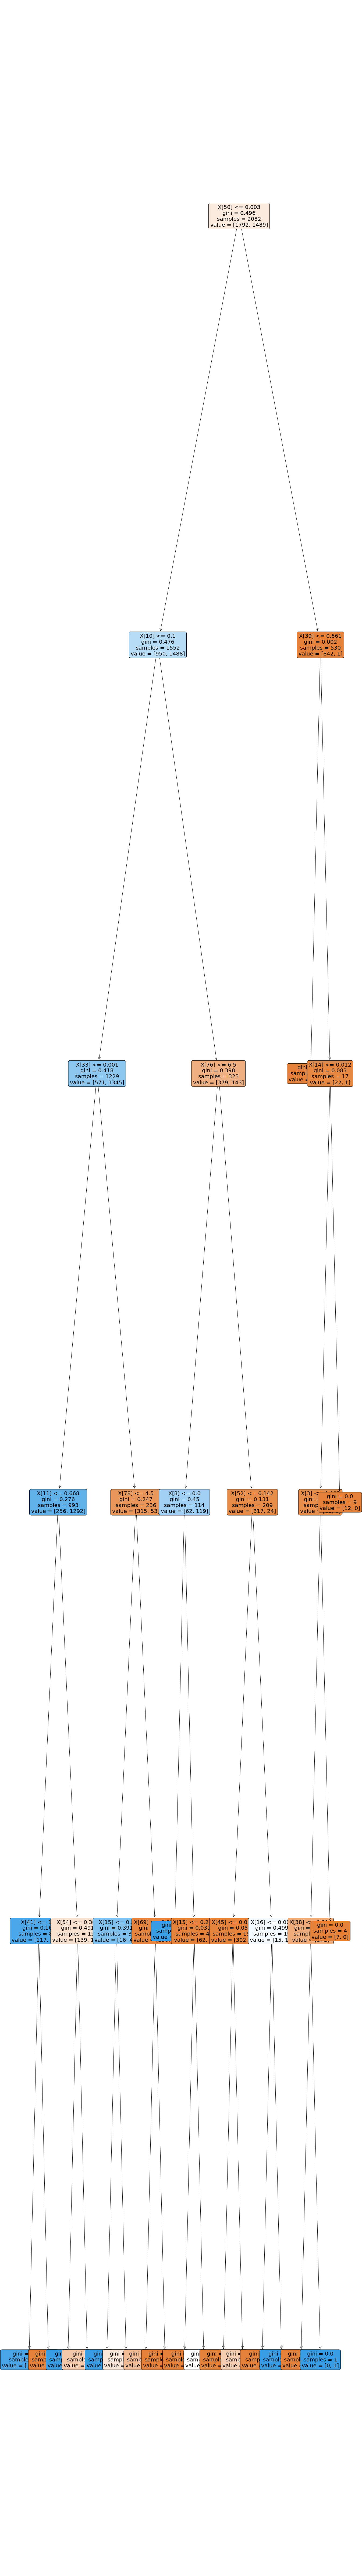

In [325]:
tree.plot_tree(rf_grid_pipe.best_estimator_._final_estimator.estimators_[1],filled=True, 
              rounded=True, 
              fontsize=20);


In [327]:
y = rf_grid_pipe.predict(dataframe.iloc[:, 1:])
y_test = dataframe.iloc[:, 0]
print(accuracy_score(y, y_test))

0.9506308283049918


In [328]:
print(classification_report(y_test, y))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95      1946
           1       0.91      0.99      0.95      1700

    accuracy                           0.95      3646
   macro avg       0.95      0.95      0.95      3646
weighted avg       0.95      0.95      0.95      3646



## LightGBM

In [364]:
parameters = {
     'task' : ['predict'],
     'boosting': ['gbdt' ],
     'objective': ['root_mean_squared_error'],
     'num_iterations': [  1500, 2000,5000  ],
     'learning_rate':[  0.05, 0.005 ],
    'num_leaves':[ 7, 15, 31  ],
    'max_depth' :[ 10,15,25],
   'min_data_in_leaf':[15,25 ],
  'feature_fraction': [ 0.6, 0.8,  0.9],
     'bagging_fraction': [  0.6, 0.8 ],
     'bagging_freq': [   100, 200, 400  ],
 }

lgb_clf = lgb.LGBMClassifier()


In [365]:
lgb_pipe = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('classifier', lgb_clf)
        ])
lgb_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('mm', MinMaxScaler(),
                                                  ['SizeOfCode',
                                                   'SizeOfInitializedData',
                                                   'SizeOfUninitializedData',
                                                   'AddressOfEntryPoint',
                                                   'BaseOfCode', 'ImageBase',
                                                   'SectionAlignment',
                                                   'FileAlignment',
                                                   'SizeOfImage',
                                                   'SizeOfHeaders', 'Subsystem',
                                                   'DllCharacteristics',
                                                   'Directory_Characteristics',
                                                   'Directory_TimeDateStamp',
                                                   'Directory_NumberOfNamedEntries',
                                                   'Directory_NumberOfIdEntries',
                                                   'e_cblp', 'e_cp', 'e_crlc',
                                                   'e_cparhdr', 'e_minalloc',
                                                   'e_maxalloc', 'e_ss', 'e_sp',
                                                   'e_csum', 'e_ip', 'e_cs',
                                                   'e_lfarlc', 'e_ovno',
                                                   'e_oemid', ...])])),
                ('classifier', LGBMClassifier())])

In [366]:
lgb_grid_pipe = GridSearchCV(lgb_pipe,
                     param_grid=param_grid, 
                    cv= 5, verbose=1)

In [367]:
lgb_grid_pipe.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Cu

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.5 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.5 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.5 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.5 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.5 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.5 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.5 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.5 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 

[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lamb

[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning

[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lamb

[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.5 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('mm',
                                                                         MinMaxScaler(),
                                                                         ['SizeOfCode',
                                                                          'SizeOfInitializedData',
                                                                          'SizeOfUninitializedData',
                                                                          'AddressOfEntryPoint',
                                                                          'BaseOfCode',
                                                                          'ImageBase',
                                                                          'SectionAlignment',
                                                                          'FileAlignment',
                                                                          'SizeOfImage',
                                                                          'SizeOfHeaders',
                                                                          'Subsystem',
                                                                          'DllCharacteristics',
                                                                          'Dir...
                                                                          'e_crlc',
                                                                          'e_cparhdr',
                                                                          'e_minalloc',
                                                                          'e_maxalloc',
                                                                          'e_ss',
                                                                          'e_sp',
                                                                          'e_csum',
                                                                          'e_ip',
                                                                          'e_cs',
                                                                          'e_lfarlc',
                                                                          'e_ovno',
                                                                          'e_oemid', ...])])),
                                       ('classifier', LGBMClassifier())]),
             param_grid={'classifier__lambda_l1': [0, 1, 1.5],
                         'classifier__lambda_l2': [0, 1],
                         'classifier__min_data_in_leaf': [30, 50, 100],
                         'classifier__num_leaves': [31, 127],
                         'classifier__reg_alpha': [0.1, 0.5]},
             verbose=1)

In [368]:
print(lgb_grid_pipe)
print(lgb_grid_pipe.best_params_)
print(lgb_grid_pipe.best_score_)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('mm',
                                                                         MinMaxScaler(),
                                                                         ['SizeOfCode',
                                                                          'SizeOfInitializedData',
                                                                          'SizeOfUninitializedData',
                                                                          'AddressOfEntryPoint',
                                                                          'BaseOfCode',
                                                                          'ImageBase',
                                                                          'SectionAlignment',
                    

In [370]:
print(accuracy_score(y_pred, y))

1.0


In [371]:
print(classification_report(y_pred, y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1806
           1       1.00      1.00      1.00      1840

    accuracy                           1.00      3646
   macro avg       1.00      1.00      1.00      3646
weighted avg       1.00      1.00      1.00      3646



## Evaluate

In [333]:
conf_matrix = confusion_matrix(y, y_test)

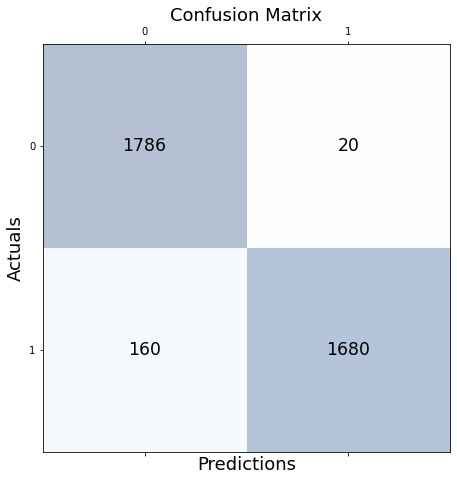

In [334]:
ig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
        
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

## Save Model

In [375]:
joblib.dump(xgb_pipe_grid, "../models/xgb_clf_model.joblib")
#xgb_clf = joblib.load("xgb_clf_model.joblib")

['./models/xgb_clf_model.joblib']

In [376]:

joblib.dump(rf_grid_pipe, "../models/rf_clf_model.joblib")
#rf_clf = joblib.load("rf_clf_model.joblib")

['./models/rf_clf_model.joblib']

In [377]:
joblib.dump(lgb_grid_pipe, "../models/lightgbm_model.joblib")
#lgb_clf = joblib.load("lightgbm_model.joblib")

['./models/lightgbm_model.joblib']